# 🚀 Clean starter notebook
This notebook pins **NumPy ≥ 2.2** _and_ **Matplotlib ≥ 3.8** so their binary interfaces match.  Run the first cell, restart the runtime, and you’re good to go.


In [1]:
# lightweight English model
!python -m spacy download en_core_web_sm -q


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


##**After the cell above finishes, restart the kernel**

In [11]:
## imports
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from datasets import load_dataset
from collections import Counter
import matplotlib.pyplot as plt
import tensorflow as tf
import spacy, warnings
from tqdm import tqdm
import pandas as pd
import numpy as np
import re

warnings.filterwarnings('ignore')

nlp = spacy.load('en_core_web_sm')


## Helper functions

In [13]:
tqdm.pandas()
dataset = load_dataset("glue", "sst2")
train_df = pd.DataFrame(dataset["train"])
# Tokenization, LemmatizationPOS-tagging
def preprocess(text):
    doc = nlp(text)
    tokens, lemmas, pos_tags = [], [], []
    for token in doc:
        if not token.is_stop and not token.is_punct:
            tokens.append(token.text)
            lemmas.append(token.lemma_)
            pos_tags.append(token.pos_)
    return {"tokens": tokens, "lemmas": lemmas, "pos_tags": pos_tags}

train_df["processed"] = train_df["sentence"].progress_apply(preprocess)
train_df["tokens"] = train_df["processed"].apply(lambda x: x["tokens"])
train_df["lemmas"] = train_df["processed"].apply(lambda x: x["lemmas"])
train_df["pos_tags"] = train_df["processed"].apply(lambda x: x["pos_tags"])
train_df.drop(columns=["processed"], inplace=True)

100%|██████████| 67349/67349 [06:13<00:00, 180.51it/s]


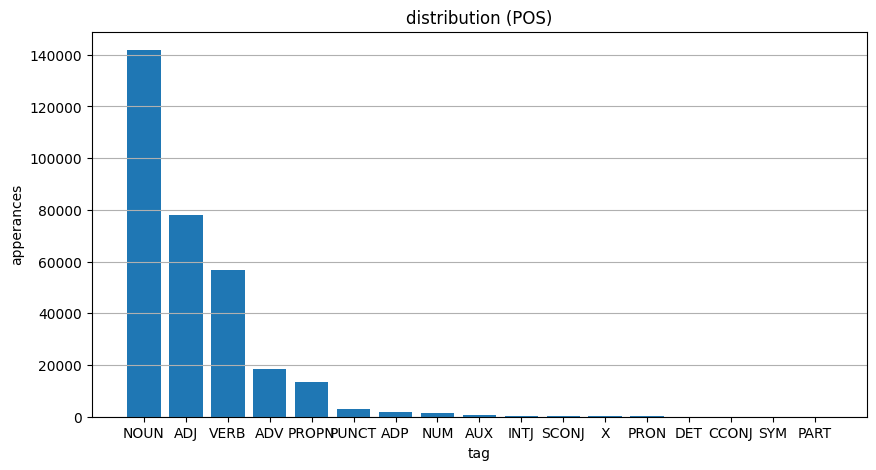

In [14]:
# Flatten all POS tags into a single list
all_tags = [tag for tags in train_df["pos_tags"] for tag in tags]

# Count tag frequencies
tag_counts = Counter(all_tags)
tag_df = pd.DataFrame(tag_counts.items(), columns=["POS", "Count"]).sort_values("Count", ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(tag_df["POS"], tag_df["Count"])
plt.title("distribution (POS)")
plt.xlabel("tag")
plt.ylabel("apperances")
plt.grid(axis="y")
plt.show()

In [15]:
# Define patterns that often trigger tagging issues
suspicious_words = ['like', 'love', 'isn\'t', 'wanna', 'gonna', 'aint', 'lol', 'u', 'ya', 'gr8', 'luv', 'bro', 'nah', 'ok']

# Function to find sentences with suspicious POS patterns
def flag_suspicious(row):
    for word, pos in zip(row['tokens'], row['pos_tags']):
        lw = word.lower()
        if lw in suspicious_words or re.match(r"\b(u|r|ya|nah|gonna|wanna|n't)\b", lw):
            return True
    return False

# Apply function to the dataset
flagged_df = train_df[train_df.apply(flag_suspicious, axis=1)]

# Show some suspicious samples
flagged_df[['sentence', 'tokens', 'pos_tags']].head(5)


,sentence,tokens,pos_tags
11,for those moviegoers who complain that ` they ...,"[moviegoers, complain, `, movies, like, anymore]","[NOUN, VERB, PUNCT, NOUN, SCONJ, ADV]"
71,sounds like a cruel deception carried out by m...,"[sounds, like, cruel, deception, carried, men,...","[VERB, ADP, ADJ, NOUN, VERB, NOUN, ADJ, NOUN, ..."
79,film to affirm love 's power to help people en...,"[film, affirm, love, power, help, people, endu...","[NOUN, ADJ, NOUN, NOUN, VERB, NOUN, VERB, ADJ,..."
82,", like life , is n't much fun without the high...","[like, life, fun, highs, lows]","[ADP, NOUN, NOUN, NOUN, NOUN]"
86,so much like a young robert deniro,"[like, young, robert, deniro]","[ADP, ADJ, PROPN, PROPN]"


# Typicall mistakes.
Row 11

Tokens: ['moviegoers', 'complain', '', 'movies', 'like', 'anymore'] 

POS Tags: [NOUN, VERB, PUNCT, NOUN, SCONJ, ADV]`

#### Error: 'like' → SCONJ

Expected: VERB or ADP (e.g., "movies like that aren't made anymore")

Explanation: The tagger likely misinterprets the sentence structure due to limited context, tagging "like" as a subordinating conjunction when it's probably used to express similarity (i.e., preposition).


----------

Row 79
Tokens: ['film', 'affirm', 'love', 'power', 'help', 'people', 'endure', ...]
POS Tags: [NOUN, ADJ, NOUN, NOUN, VERB, NOUN, VERB, ...]

#### Error: 'affirm' → ADJ

Expected: VERB ("to affirm love’s power...")

Explanation: Likely due to parsing confusion with the infinitive structure. "affirm" is used as a verb, but the parser treats it as an adjective (possibly mistaking "film" as its noun subject).

In [16]:
# -- Step 7: Optimized Word Embeddings

def get_embedding_fast(tokens):
    vecs = [nlp.vocab[token].vector for token in tokens if nlp.vocab[token].has_vector]
    return np.mean(vecs, axis=0) if vecs else np.zeros(nlp.vocab.vectors_length)

train_df["embedding"] = train_df["lemmas"].progress_apply(get_embedding_fast)
X_no_pos = np.vstack(train_df["embedding"].values)
print("Embedding matrix (no POS):", X_no_pos.shape)

# Step 8: Embeddings With POS Enrichment ----
# Create "lemma_POS" style tokens
train_df["lemma_pos"] = train_df.apply(
    lambda row: [f"{lemma}_{pos}" for lemma, pos in zip(row["lemmas"], row["pos_tags"])],
    axis=1
)

def get_embedding_with_pos(tokens):
    vecs = [nlp.vocab[token.split("_")[0]].vector for token in tokens if nlp.vocab[token.split("_")[0]].has_vector]
    return np.mean(vecs, axis=0) if vecs else np.zeros(nlp.vocab.vectors_length)

train_df["embedding_pos"] = train_df["lemma_pos"].progress_apply(get_embedding_with_pos)
X_with_pos = np.vstack(train_df["embedding_pos"].values)
print("Embedding matrix (with POS):", X_with_pos.shape)


100%|██████████| 67349/67349 [00:00<00:00, 142713.46it/s]


Embedding matrix (no POS): (67349, 0)


100%|██████████| 67349/67349 [00:00<00:00, 146908.37it/s]


Embedding matrix (with POS): (67349, 0)


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, f1_score, precision_score
import numpy as np
import pandas as pd

# Prepare data
train_df['joined_lemmas'] = train_df['lemmas'].apply(lambda x: ' '.join(x))
train_df['joined_lemma_pos'] = train_df['lemma_pos'].apply(lambda x: ' '.join(x))

tokenizer1 = Tokenizer()
tokenizer2 = Tokenizer()
tokenizer1.fit_on_texts(train_df['joined_lemmas'])
tokenizer2.fit_on_texts(train_df['joined_lemma_pos'])

seq1 = tokenizer1.texts_to_sequences(train_df['joined_lemmas'])
seq2 = tokenizer2.texts_to_sequences(train_df['joined_lemma_pos'])

max_len = max(max(len(seq) for seq in seq1), max(len(seq) for seq in seq2))
X1 = pad_sequences(seq1, maxlen=max_len)
X2 = pad_sequences(seq2, maxlen=max_len)
y = train_df["label"].values

# Train/test split
split_idx = int(0.8 * len(X1))
X1_train, X1_test = X1[:split_idx], X1[split_idx:]
X2_train, X2_test = X2[:split_idx], X2[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Define model builder
def build_lstm_model(vocab_size, max_len, lr):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
    model.add(LSTM(64))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )
    return model

# Run experiments
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.25]
results = []

for lr in learning_rates:
    print(f"\nTraining with learning rate = {lr}")

    model_lemma = build_lstm_model(len(tokenizer1.word_index) + 1, max_len, lr)
    model_pos   = build_lstm_model(len(tokenizer2.word_index) + 1, max_len, lr)

    model_lemma.fit(X1_train, y_train, epochs=3, batch_size=32, verbose=0)
    model_pos.fit(X2_train, y_train, epochs=3, batch_size=32, verbose=0)

    preds1 = model_lemma.predict(X1_test).flatten()
    preds2 = model_pos.predict(X2_test).flatten()

    preds1_bin = (preds1 > 0.5).astype(int)
    preds2_bin = (preds2 > 0.5).astype(int)

    results.append({
        "lr": lr,
        "acc_no_pos": accuracy_score(y_test, preds1_bin),
        "f1_no_pos": f1_score(y_test, preds1_bin),
        "prec_no_pos": precision_score(y_test, preds1_bin),
        "acc_with_pos": accuracy_score(y_test, preds2_bin),
        "f1_with_pos": f1_score(y_test, preds2_bin),
        "prec_with_pos": precision_score(y_test, preds2_bin),
    })

# Show results
results_df = pd.DataFrame(results)
print(results_df)



Training with learning rate = 0.001
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Training with learning rate = 0.005
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Training with learning rate = 0.01
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Training with learning rate = 0.05
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Training with learning rate = 0.1
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Training with learning rate = 0.25
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
      lr  acc_no_pos  f1_no_pos  prec_no_pos  acc_with_pos  f1_with_pos  \
0  0.001    0.894506   0.906396     0.894320      0.892947     0.905455   
1  0.005    0.894655   0.906675     0.893223      0.894135     0.905887   
2  0.010    0.884113   0.896023     0.893821      0.883148     0.8

# Completly counterintutive to what we thought the addition of pos tagging didn't improve our accuracy.
# The reasons mentioned in the internet said that:
### Pos tagging might be noisy on informal texts - making the results worse.
### pretrained embedding aldready capture syntactic roles.
### So basically the pos embedding might help in other cases in formal text etc... but not in our case.

In [30]:
from sklearn.metrics import accuracy_score, f1_score, precision_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

# Prepare sequences
tokenizer1 = Tokenizer()
tokenizer2 = Tokenizer()

tokenizer1.fit_on_texts(train_df["lemmas"])
tokenizer2.fit_on_texts(train_df["lemma_pos"])

seq1 = tokenizer1.texts_to_sequences(train_df["lemmas"])
seq2 = tokenizer2.texts_to_sequences(train_df["lemma_pos"])

max_len = max(max(len(s) for s in seq1), max(len(s) for s in seq2))
X1 = pad_sequences(seq1, maxlen=max_len)
X2 = pad_sequences(seq2, maxlen=max_len)
y = train_df["label"].values

# Split
split_idx = int(0.8 * len(X1))
X1_train, X1_test = X1[:split_idx], X1[split_idx:]
X2_train, X2_test = X2[:split_idx], X2[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Build MLP model
def build_simple_nn(vocab_size, input_len):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=64, input_length=input_len),
        GlobalAveragePooling1D(),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create and train models
model_lemma = build_simple_nn(len(tokenizer1.word_index) + 1, max_len)
model_pos   = build_simple_nn(len(tokenizer2.word_index) + 1, max_len)

model_lemma.fit(X1_train, y_train, epochs=5, batch_size=32, verbose=0)
model_pos.fit(X2_train, y_train, epochs=5, batch_size=32, verbose=0)

# Predict
y_pred_lemma = (model_lemma.predict(X1_test).ravel() >= 0.5).astype(int)
y_pred_pos   = (model_pos.predict(X2_test).ravel() >= 0.5).astype(int)

# Evaluate
acc1  = accuracy_score(y_test, y_pred_lemma)
f1_1  = f1_score(y_test, y_pred_lemma)
prec1 = precision_score(y_test, y_pred_lemma)

acc2  = accuracy_score(y_test, y_pred_pos)
f1_2  = f1_score(y_test, y_pred_pos)
prec2 = precision_score(y_test, y_pred_pos)

# Report
print("Simple NN WITHOUT POS  Accuracy:", acc1, "F1:", f1_1, "Precision:", prec1)
print("Simple NN WITH POS     Accuracy:", acc2, "F1:", f1_2, "Precision:", prec2)


421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Simple NN WITHOUT POS  Accuracy: 0.8804751299183371 F1: 0.8942181340341656 Precision: 0.8801086394205898
Simple NN WITH POS     Accuracy: 0.8714922048997773 F1: 0.891097829506134 Precision: 0.8423932437254669
